# This is an example notebook for running the CSU_Radartools hydrometeor identificaiton on gridded netcdf files

## Brenda Dolan, October 2020

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from netCDF4 import Dataset


import matplotlib.colors as colors

from skewPy import SkewT
from pathlib import Path

#from CSU_RadarTools import csu_radartools
from CSU_RadarTools.csu_radartools import csu_fhc

%matplotlib inline



# These are some helper functions

In [7]:
## setup the summre colors.
hid_colors =  ['White','LightBlue','MediumBlue','Darkorange','LightPink','Cyan','DarkGray',\
            'Lime','Yellow','Red','Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)

labelhid=['Drizzle','Rain', 'IC', 'AG', 'WS',
                           'VI', 'LDG','HDG','HA','BD']



##Setup the winter colors.

hid_colors_winter = ['White','Orange', 'Purple', 'Fuchsia', 'Pink', 'Cyan',
              'LightBlue', 'Blue']#, 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphidwinter = colors.ListedColormap(hid_colors_winter)


labelhca=['IC','Plates', 'Dendrites', 'Aggregates', 'Wet Snow',
                           'LightRain', 'Rain']


def interpolate_sounding_to_grid(sounding, radar_z, dz):
    """Takes sounding data and interpolates it to every radar gate."""
    #radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    #print (snd_z)
    whgd = np.where(np.logical_and(np.array(snd_T)>-99,np.array(snd_z)>0.))
    shape = np.shape(dz)
#    print 'Shape: ',shape
    rad_z1d = radar_z*1000.
    rad_T1c = np.interp(rad_z1d, snd_z[whgd], snd_T[whgd])
    #print(snd_z,snd_T)
    tfixed=np.zeros(dz.shape)
    zfixed=np.zeros(dz.shape)
    for i in range(len(radar_z)):
        tfixed[i,:,:] = rad_T1c[i]
        zfixed[i,:,:] = rad_z1d[i]

    return tfixed, zfixed

def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding['temp']  # In old SkewT, was sounding.data
    snd_z = sounding['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    #print(snd_T.mask)
    if not snd_T.mask.all(): #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    if np.isfinite(snd_z[i]) and np.isfinite(snd_T[i]):
                        #print(snd_T[i])
                        dummy_z.append(snd_z[i])
                        dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    else:
        print('uh-oh. sounding problem')
    return snd_T, snd_z




### Read in the data

In [8]:
radardata = Dataset('oly_npol_cart20151205_152002.nc')

In [9]:
###all of the HIDs will be improved by including temperature data. This is not required, but
###definitely helps. The temperature just has to be the same shape / size as the radar data.

#I am going to read in a sounding and interpolate it to the radar gates. You could also use
#reanalysis data, or a assumed temperature profile.

##The HCA "winter HID" does better if there is an expected melting layer to determine how far
##the polarimetrically identified ML deviates from the assumed profile.

sounding = SkewT.Sounding('20151117_12z_QUIL.txt')
wh0 = np.where(np.isclose(np.abs(sounding['temp']),0.0,atol=1.0))
expected_ML = np.array(sounding['hght'])[wh0[0]][0]/1000.

z = radardata['z0'][:]
dz =np.squeeze(radardata['CZ'][:])


####Interpolate the sounding to the radar heights
radar_T, radar_z = interpolate_sounding_to_grid(sounding,z,dz)

In [10]:
np.shape(radar_z)

(17, 301, 301)

# HCA "winter"
Thompson, E. J., Rutledge, S. A., Dolan, B., Chandrasekar, V., & Cheong, B. L. (2014). A dual-polarization radar hydrometeor classification algorithm for winter precipitation. Journal of Atmospheric and Oceanic Technology, 31(7), 1457-1481.

#### Cateories:
#### 0  = Unclassified
#### 1  = Ice Crystals
#### 2  = Plates
#### 3  = Dendrites
#### 4  = Aggregates
#### 5  = Wet Snow
#### 6  = Frozen precip
#### 7  = Rain


In [11]:
##The winter algorithm relies heavliy on Zdr, Kdp, and Rhohv so including these is critical.
##The radar heights should be in km, as should the expected melting layer.
#We also need the radar scan type (ppi or rhi) to determien the best way to find the bright band.

#setup some things needed by the HCA. You can also pass these directly in but I've listed them
#out here for clarity.
rband = 'S'                 #Radar band -- critical for selecting the approproate beta functions
use_temp = True             #use the temperature
verbose = False             #Do not print out verbose 
minRH = 0.5                 #Since RH is so important for ML detection, there is a minimum rho 
                            #threshold for good data
rheights = radar_z/1000.    #radar heights should be in km.

return_scores = False      #For certain things, like testing the relative scoring for 2nd place
                            #categories, you might want to return the whole score matrix, including
                            #for each of the intermediate fuzzy logic steps such as the melting level
                            #scoring. Otherwise it will just return the highest ranking category.

#If signal to noise ratio is available, the results of the classification 
#will be improved 

##For the gridded version, there are no azimuths. So it is easier to run the RHI version of the melting layer algorithm

scan_type = 'grid' #rhi, ppi, or grid determines how the melting layer identification will be done. It gets a little weird
                    #for gridded data. Right now the ice species are used at the melting layer height with the wet snow.



#Radar variables. These should be just the data (not an object), and masked arrays
dz = np.squeeze(np.ma.masked_array(radardata['CZ'][:]))
dr = np.squeeze(np.ma.masked_array(radardata['CR'][:]))
kd = np.squeeze(np.ma.masked_array(radardata['KD'][:]))
rh = np.squeeze(np.ma.masked_array(radardata['RH'][:]))



hcawinter = csu_fhc.run_winter(dz=dz,zdr=dr,kdp=kd,rho=rh,
                              expected_ML=expected_ML,sn=None,T=radar_T,heights=rheights,
                              scan_type = scan_type,verbose=verbose,use_temp = use_temp,
                              band=rband, return_scores=return_scores)






Melting level height:2.00
RADAR MELTING IS: 2.0


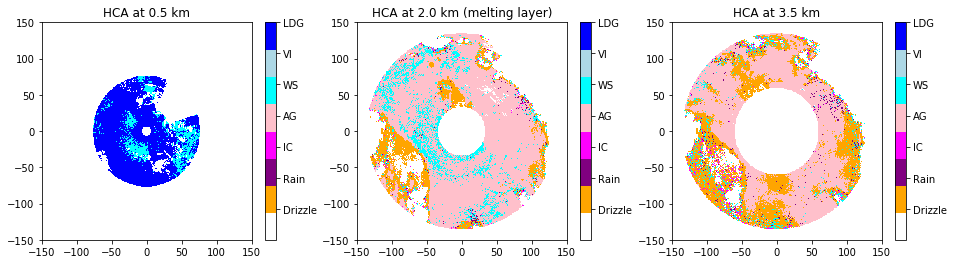

In [12]:
###Let's see what we got.
fig, ax = plt.subplots(1,3,figsize=(16,4))
axf=ax.flatten()

axf[0].pcolormesh(radardata['x0'],radardata['y0'],hcawinter[0,...],cmap=cmaphidwinter,vmin=0,vmax=7)
axf[0].set_title(f'HCA at {z[0]} km')

axf[1].pcolormesh(radardata['x0'],radardata['y0'],hcawinter[3,...],cmap=cmaphidwinter,vmin=0,vmax=7)
axf[1].set_title(f'HCA at {z[3]} km (melting layer)')

c = axf[2].pcolormesh(radardata['x0'],radardata['y0'],hcawinter[6,...],cmap=cmaphidwinter,vmin=0,vmax=7)
axf[2].set_title(f'HCA at {z[6]} km')

for i in axf:
    cb =plt.colorbar(c,ax =i)
    cb.set_ticks([1,2,3,4,5,6,7,8,9,10])
    cb.set_ticklabels(labelhid)



# HID "summer"
Dolan, B., S. A. Rutledge, S. Lim, V. Chandrasekar, and M. Thurai, 2013: A robust C-band hydrometeor identification algorithm and application to a long term polarimetric radar data set. J. Appl. Meteor., 52, 2162-2186.

Dolan, B., and S. A. Rutledge, 2009: A theory-based hydrometeor identification algorithm for X-band polarimetric radars. J. Oceanic Atmos. Technol., 46, 1196-1213, 10.1175/2009JTECHA1208.1.


#### Cateories:
#### 0  = Unclassified
#### 1  = Drizzle
#### 2  = Rain
#### 3  = Dry snow
#### 4  = Aggregates
#### 5  = Wet Snow
#### 6  = Vertical Ice
#### 7  = Low-density graupel
#### 8  = High-density graupel
#### 9 = Hail
#### 10 = Big drops / melting hail



In [13]:
##Let's see how the winter compares with the summer.

## We will start by using the temperature beta funcitons, and the hybrid scoring method.

hid = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True,T=radar_T, band=rband,
                                verbose=False,use_trap=False,method='hybrid')#,fdir ='/home/bdolan/python/CSU_RadarTools/csu_radartools/beta_function_parameters/')
#Use the reflectivity mask
hid = np.ma.masked_where(dz.mask,hid)

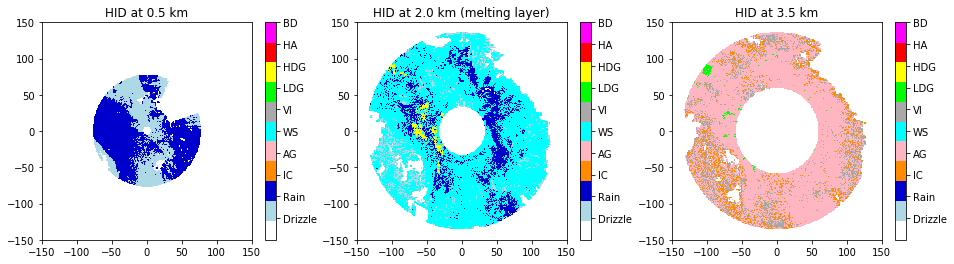

In [14]:
###Let's see what we got.
fig, ax = plt.subplots(1,3,figsize=(16,4))
axf=ax.flatten()

axf[0].pcolormesh(radardata['x0'],radardata['y0'],hid[0,...],cmap=cmaphid,vmin=0,vmax=10)
axf[0].set_title(f'HID at {z[0]} km')

axf[1].pcolormesh(radardata['x0'],radardata['y0'],hid[3,...],cmap=cmaphid,vmin=0,vmax=10)
axf[1].set_title(f'HID at {z[3]} km (melting layer)')

c = axf[2].pcolormesh(radardata['x0'],radardata['y0'],hid[6,...],cmap=cmaphid,vmin=0,vmax=10)
axf[2].set_title(f'HID at {z[6]} km')

for i in axf:
    cb =plt.colorbar(c,ax =i)
    cb.set_ticks([1,2,3,4,5,6,7,8,9,10])
    cb.set_ticklabels(labelhid)



In [15]:
###Now what happens if we use the trapazoidal functions and the 'linear' scoring?
hidT = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True,T=radar_T, band=rband,
                                verbose=False,use_trap=True,method='linear')#,fdir ='/home/bdolan/python/CSU_RadarTools/csu_radartools/beta_function_parameters/')


#Use the reflectivity mask
hidT = np.ma.masked_where(dz.mask,hidT)

0.5


Text(0.5, 0.98, 'Trapezoidal T functions')

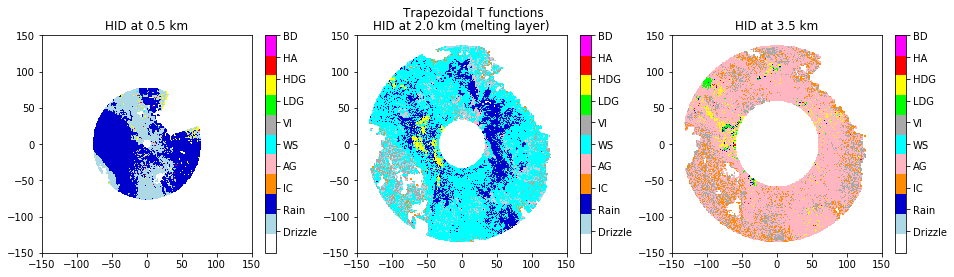

In [16]:
###Let's see what we got.
fig, ax = plt.subplots(1,3,figsize=(16,4))
axf=ax.flatten()

axf[0].pcolormesh(radardata['x0'],radardata['y0'],hidT[0,...],cmap=cmaphid,vmin=0,vmax=10)
axf[0].set_title(f'HID at {z[0]} km')

axf[1].pcolormesh(radardata['x0'],radardata['y0'],hidT[3,...],cmap=cmaphid,vmin=0,vmax=10)
axf[1].set_title(f'HID at {z[3]} km (melting layer)')

c = axf[2].pcolormesh(radardata['x0'],radardata['y0'],hidT[6,...],cmap=cmaphid,vmin=0,vmax=10)
axf[2].set_title(f'HID at {z[6]} km')

for i in axf:
    cb =plt.colorbar(c,ax =i)
    cb.set_ticks([1,2,3,4,5,6,7,8,9,10])
    cb.set_ticklabels(labelhid)

plt.suptitle('Trapezoidal T functions')
